# 

In [1]:
import struct

import numpy as np
import matplotlib.pyplot as plt

from scipy.constants import pi, c
from scipy.fft import fft, ifft, fftshift, ifftshift, ifft2, fft2

from decoding import get_header_dict, packet_generator_from_file, packet_generator, build_data_word_dict, index_decoder, annotation_decoder
from packet import Packet
from utils import create_bit_string, find_packet_of_type, time_packet_generation

In [2]:
def plot_signal(signal, title=""):
    fig = plt.figure()
    fig.set_size_inches(12, 2)
    plt.plot(signal)
    plt.title(title)

def plot_signals(signals, title="", vmax=None):
    fig = plt.figure()
    fig.set_size_inches(12, 3)
    if vmax is not None:
        plt.imshow(signals, cmap='jet', aspect='auto', vmax=vmax)
    else:
        plt.imshow(signals, cmap='jet', aspect='auto')
    plt.title(title)

In [3]:
raw_data = open('../../sentinel1_decode/data/sample/sample.dat', 'rb')

In [4]:
def get_packets_in_swath(data, swath_num):
    PacketGenerator = packet_generator(raw_data)
    swath_packets = []
    packet_index = 0
    while (raw_data):
        try:
            packet = next(PacketGenerator)
            if packet.data_format() == 'D':
                if packet.get_secondary_header()['swath_number'] == swath_num:
                    swath_packets.append((packet, packet_index))
            packet_index += 1
        except ValueError as ve:
            break
    return swath_packets      

In [5]:
swath_packets = get_packets_in_swath(raw_data, 10)

In [6]:
def get_packets_in_bursts(swath_packets):
    bursts = []
    burst_packets = []
    previous_az = 0
    index = 0
    for packet, packet_index in swath_packets:
        az = packet.get_secondary_header()['azimuth_beam_address']
        if index == 0:
            previous_az = az
        if az != previous_az and az != previous_az + 1:
            bursts.append(burst_packets)
            burst_packets = []
        burst_packets.append((packet, packet_index))
        previous_az = az
        if index == len(swath_packets) - 1:
            bursts.append(burst_packets)
        index += 1
    return bursts

def get_packets_in_burst(swath_packets, burst_num):
    bursts = get_packets_in_bursts(swath_packets)
    return bursts[burst_num]

In [7]:
swath_packets

[(Packet Type: D
  --------------
  
  Primary Header:
  ---------------
  Packet Version Number: 0
  Packet Type: 0
  Secondary Header Flag: 1
  Process ID: 65
  Process Category: 12
  Packet Sequence Count: 11157
  Packet Data Length: 18621
  
  Secondary Header:
  -----------------
  Coarse Time: 1406987562
  Fine Time: 7757
  Sync Marker: 892270675
  Data Take ID: 225252800
  Sensor Mode: interferomatric_wide_swath
  Test Mode: measurement_mode
  RX Channel ID: V
  Instrument Configuration ID: 7
  Sub-Commutative Word Index: 27
  Sub-Commutative Word: 1011111011000011
  Space Packet Count: 240533
  PRI Count: 243384
  Error Flag: nominal
  BAQ Mode: fdbaq_mode_0
  BAQ Block Length: 256
  Range Decimation: 8
  RX Gain: -4.0
  TX Ramp Rate: 1.078230321255918
  Pulse Start Frequency: -28.251534196373175
  Pulse Length: 52.40481033595628
  Rank: 9
  PRI: 582.3674372819869
  SWST: 98.06919514319017
  SWL: 372.4284919605149
  SSB Flag: 0
  Polarisation: V
  Temperature Compensation: 3
  

In [8]:
burst_ = get_packets_in_burst(swath_packets, 10)
burst = []
for packet, packet_index in burst_:
    burst.append(packet)

In [8]:
def decode_signals(packets):
    signals = []
    index = 0
    for packet in packets:
        if index % 100 == 0:
            print(f"{index} of {len(packets)}")
        signals.append(packet.get_complex_samples()[0])
        index += 1
    return np.asarray(signals)

In [9]:
do_decode = False
save_decode = False
load_signals = True

if do_decode:
    signals = decode_signals(burst)
    if save_decode:
        np.save("burst_iw1_10.npy", signals)
if load_signals:
    # signals = np.load("burst_iw1_5.npy")
    signals = np.load("burst_iw1_10.npy")

In [10]:
header = burst[0].get_secondary_header()

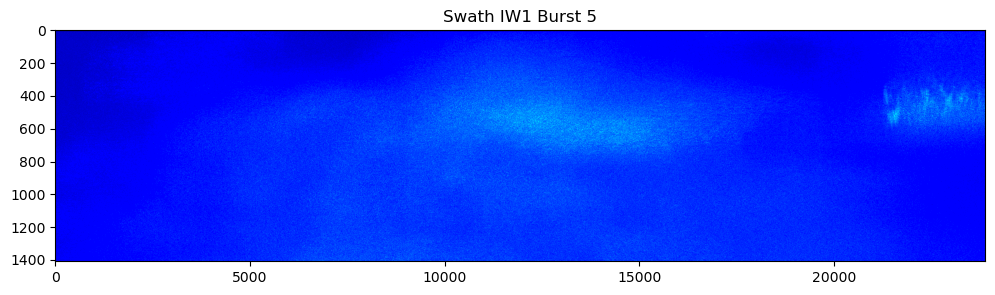

In [11]:
plot_signals(np.abs(signals) / np.max(np.abs(signals)), title="Swath IW1 Burst 5")

In [12]:
range_decimation_list = [
    112.6041667,
    100.0925926,
    0.000000000,
    83.41049387,
    66.72839509,
    56.30208336,
    50.04629632,
    25.02314816,
    64.34523813,
    46.91840280,
    17.32371796,
    54.59595962
]

def get_replica_chirps(packets):
    replica_chirps = []
    for packet in packets:
        secondary_header = packet.get_secondary_header()
        range_decimation = secondary_header['range_decimation']
        txpsf = secondary_header['tx_pulse_start_frequency']
        txprr = secondary_header['tx_ramp_rate']
        txpl  = secondary_header['pulse_length']
        phi_1 = txpsf
        phi_2 = txprr / 2
        fs = int(np.floor(range_decimation_list[range_decimation] * txpl))
        t = np.linspace(0.0, txpl, fs)
        chirp = (1 / fs) * np.exp(2 * pi * 1j * (phi_1 * t + phi_2 * (t**2)))
        replica_chirps.append(chirp)
    return np.asarray(replica_chirps)

In [13]:
replica_chirps = get_replica_chirps(burst)

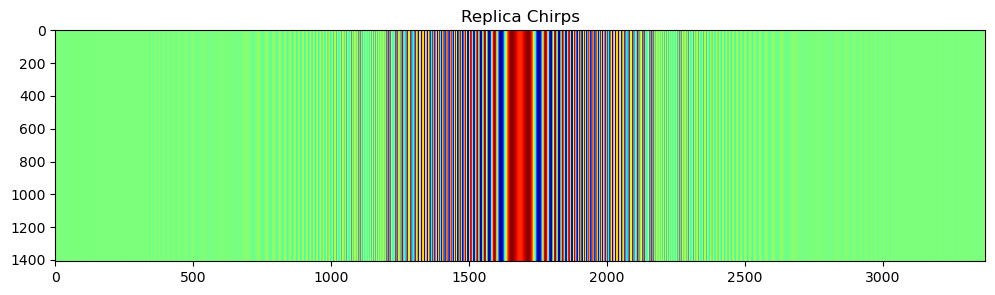

In [14]:
plot_signals(replica_chirps.real, title="Replica Chirps")

In [15]:
def get_reference_function(replica, ref_samples):
    rep_samples = replica.shape[0]
    
    ref_func = np.zeros(ref_samples, dtype=complex)
    ref_func[0:rep_samples] = replica
    
    window = np.hanning(ref_samples)
    reference = np.conj(ref_func) * window

    norm = np.abs(reference)
    energy = 0.0
    for i in range(ref_samples):
        energy += (norm[i] * norm[i])
    energy /= ref_samples
    
    for i in range(ref_samples):
        reference[i] = reference[i] / energy

    return np.asarray(reference)

def pulse_compression(chirp, replica):
    pulse_compressed = []
    f_chirp = fft(chirp)
    ref_samples = chirp.shape[0]
    ref_func = get_reference_function(replica, ref_samples)
    f_ref_func = fft(ref_func)
    for i in range(ref_samples):
        pulse_compressed.append(f_chirp[i] * f_ref_func[i])
    return ifft(np.asarray(pulse_compressed))

In [16]:
from datetime import datetime, timedelta

azimuth_steering_rate = 1.590368784000000e+00
wavelength = c / 5.405000454334350e+09
velocity = 7594.502898410107

doppler_centroid_rate = -1 * (2 * velocity / wavelength) * azimuth_steering_rate

def gps_time_to_seconds_since_midnight(gps_time_seconds):
    # Define the GPS epoch (January 6, 1980, 00:00:00 UTC)
    gps_epoch = datetime(1980, 1, 6)
    
    # Split the GPS time into seconds and fractional seconds
    whole_seconds = int(gps_time_seconds)
    fractional_seconds = gps_time_seconds - whole_seconds
    
    # Convert the GPS time (whole seconds) to a datetime object
    current_time = gps_epoch + timedelta(seconds=whole_seconds)
    
    # Get the number of seconds since the beginning of the day with sub-second precision
    seconds_since_midnight = (
        current_time.hour * 3600 +
        current_time.minute * 60 +
        current_time.second +
        fractional_seconds  # Add the fractional part
    )
    
    return seconds_since_midnight


first_line_time = (13 * 60 * 60) + (49 * 60) + 54.908760
last_line_time  = (13 * 60 * 60) + (50 * 60) + 22.681255

azimuth_samples = len(burst)

n = np.linspace(first_line_time, last_line_time, azimuth_samples)

burst_time = gps_time_to_seconds_since_midnight(header["coarse_time"] + (1 / header["fine_time"]))

gps_time_base = (2024 - 1980)

deramping_signal = np.exp(1j * pi * doppler_centroid_rate * (n - (burst_time / 2)**2))

def deramp_signal(chirp, replica):
    pulse_compressed = []
    f_chirp = fft(chirp)
    ref_samples = chirp.shape[0]
    ref_func = get_reference_function(replica, ref_samples)
    f_ref_func = fft(ref_func)
    for i in range(ref_samples):
        pulse_compressed.append(f_chirp[i] * f_ref_func[i])
    return ifft(np.asarray(pulse_compressed))

In [17]:
def de(chirp, replica):
    pulse_compressed = []
    f_chirp = fft(chirp)
    ref_samples = chirp.shape[0]
    ref_func = get_reference_function(replica, ref_samples)
    f_ref_func = fft(ref_func)
    for i in range(ref_samples):
        pulse_compressed.append(f_chirp[i] * f_ref_func[i])
    return ifftshift(ifft(np.asarray(pulse_compressed)))

In [18]:
pulse_compressed_signal = pulse_compression(signals[0], replica_chirps[0])

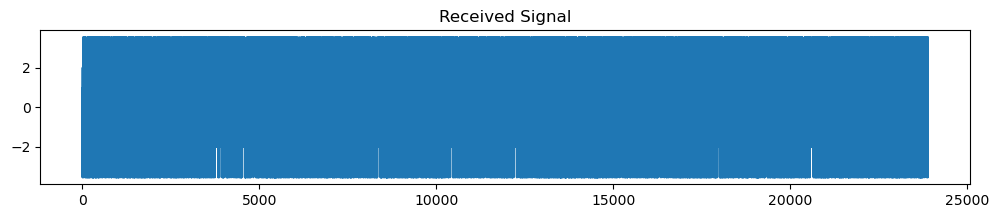

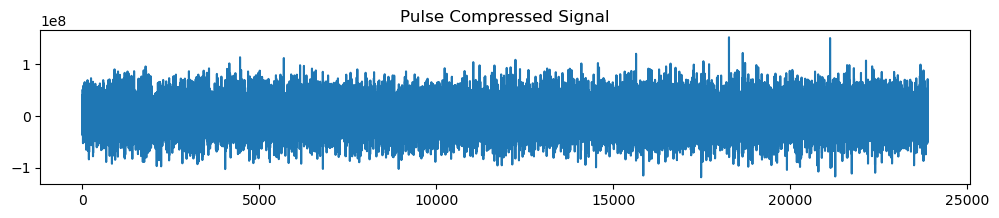

In [19]:
plot_signal(signals[0].real, title="Received Signal")
plot_signal(pulse_compressed_signal.real, title="Pulse Compressed Signal")

In [20]:
def range_compress_burst(signals, replica_chirps):
    num_packets = signals.shape[0]
    range_compressed_signals = np.zeros_like(signals)
    for i in range(num_packets):
        range_compressed_signals[i] = pulse_compression(signals[i], replica_chirps[i])
    return range_compressed_signals

In [21]:
range_compressed_burst = range_compress_burst(signals, replica_chirps)

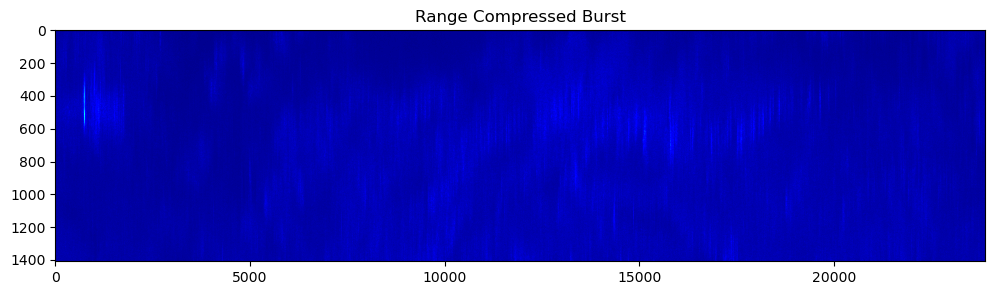

In [22]:
plot_signals(np.abs(range_compressed_burst) / np.max(np.abs(range_compressed_burst)), title="Range Compressed Burst")

In [23]:
from datetime import datetime, timedelta

azimuth_steering_rate = 1.590368784000000e+00
wavelength = c / 5.405000454334350e+09
velocity = 7594.502898410107

doppler_centroid_rate = -1 * (2 * velocity / wavelength) * azimuth_steering_rate

def gps_time_to_seconds_since_midnight(gps_time_seconds):
    # Define the GPS epoch (January 6, 1980, 00:00:00 UTC)
    gps_epoch = datetime(1980, 1, 6)
    
    # Split the GPS time into seconds and fractional seconds
    whole_seconds = int(gps_time_seconds)
    fractional_seconds = gps_time_seconds - whole_seconds
    
    # Convert the GPS time (whole seconds) to a datetime object
    current_time = gps_epoch + timedelta(seconds=whole_seconds)
    
    # Get the number of seconds since the beginning of the day with sub-second precision
    seconds_since_midnight = (
        current_time.hour * 3600 +
        current_time.minute * 60 +
        current_time.second +
        fractional_seconds  # Add the fractional part
    )
    
    return seconds_since_midnight


first_line_time = (13 * 60 * 60) + (49 * 60) + 54.908760
last_line_time  = (13 * 60 * 60) + (50 * 60) + 22.681255

azimuth_samples = len(burst)

n = np.linspace(first_line_time, last_line_time, azimuth_samples)

burst_time = gps_time_to_seconds_since_midnight(header["coarse_time"] + (1 / header["fine_time"]))

gps_time_base = (2024 - 1980)

deramping_signal = np.exp(1j * pi * doppler_centroid_rate * (n - (burst_time / 2)**2))

rows = range_compressed_burst.shape[0]
cols = range_compressed_burst.shape[1]

for i in range(rows):
    range_compressed_burst[:, i] *= deramping_signal

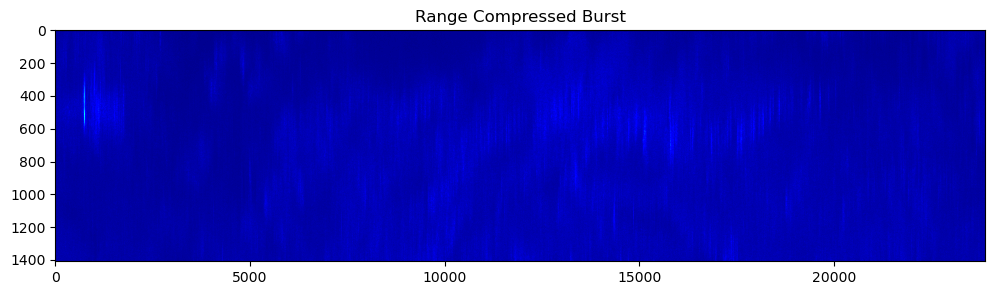

In [24]:
plot_signals(np.abs(range_compressed_burst) / np.max(np.abs(range_compressed_burst)), title="Range Compressed Burst")

In [25]:
range_doppler_burst = fft(range_compressed_burst, axis=0)

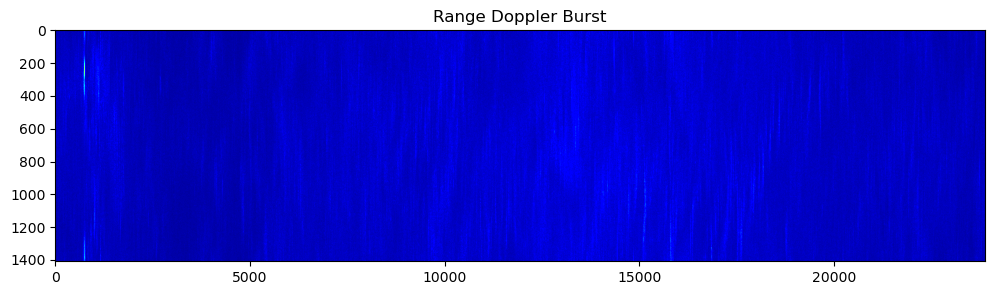

In [26]:
plot_signals(np.abs(range_doppler_burst), title="Range Doppler Burst")

In [27]:
from structs import SUB_COMM_KEY_POS, SUB_COMM_KEY_VAL, WORD_SIZE

def to_float32(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('f', struct.pack('I', int_representation))[0]
    return float_value

def to_float64(bit_string):
    int_representation = int(bit_string, 2)
    float_value = struct.unpack('d', struct.pack('Q', int_representation))[0]
    return float_value

def build_data_word_dict(packets):
    data_word_dicts = []
    sub_comm_dict = SUB_COMM_KEY_VAL.copy()
    
    initial_data_word_index = 0
    sc_data_word_index = 0

    for i in range(len(packets)):
        packet = packets[i]
        
        secondary_header = packet.get_secondary_header()
        
        sc_data_word_index = secondary_header['sc_data_word_index']

        if i == 0:
            initial_data_word_index = sc_data_word_index
        else:
            if sc_data_word_index == initial_data_word_index:
                data_word_dicts.append(sub_comm_dict)
                sub_comm_dict = SUB_COMM_KEY_VAL.copy()

        data_word =  secondary_header['sc_data_word']

        key, pos = SUB_COMM_KEY_POS[sc_data_word_index]
        pos = pos * WORD_SIZE
        sub_comm_dict[key] = sub_comm_dict[key][0:pos] + data_word + sub_comm_dict[key][pos+WORD_SIZE:]
    
    if sc_data_word_index != initial_data_word_index:
        data_word_dicts.append(sub_comm_dict)

    for i in range(len(data_word_dicts)):
        data_word_dicts[i]['x_axis_position'] = to_float64(data_word_dicts[i]['x_axis_position'])
        data_word_dicts[i]['y_axis_position'] = to_float64(data_word_dicts[i]['y_axis_position'])
        data_word_dicts[i]['z_axis_position'] = to_float64(data_word_dicts[i]['z_axis_position'])
        data_word_dicts[i]['x_axis_velocity'] = to_float32(data_word_dicts[i]['x_axis_velocity'])
        data_word_dicts[i]['y_axis_velocity'] = to_float32(data_word_dicts[i]['y_axis_velocity'])
        data_word_dicts[i]['z_axis_velocity'] = to_float32(data_word_dicts[i]['z_axis_velocity'])
        data_word_dicts[i]['q0_quaternion']   = to_float32(data_word_dicts[i]['q0_quaternion'])
        data_word_dicts[i]['q1_quaternion']   = to_float32(data_word_dicts[i]['q1_quaternion'])
        data_word_dicts[i]['q2_quaternion']   = to_float32(data_word_dicts[i]['q2_quaternion'])
        data_word_dicts[i]['q3_quaternion']   = to_float32(data_word_dicts[i]['q3_quaternion'])
        data_word_dicts[i]['omega_x']         = to_float32(data_word_dicts[i]['omega_x'])
        data_word_dicts[i]['omega_y']         = to_float32(data_word_dicts[i]['omega_y'])
        data_word_dicts[i]['omega_z']         = to_float32(data_word_dicts[i]['omega_z'])

    return data_word_dicts

data_word_dicts = build_data_word_dict(burst)

def time_stamp_to_seconds(time_stamp):
    time_stamp = time_stamp[8:64]
    num = 0
    for i in range(0, 32):
        num += int(time_stamp[i]) * (2 ** (32-i-1))
    for i in range(33, 56):
        num += int(time_stamp[i]) * (2 ** (-i))
    return num

def quaternion_to_rotation_matrix(q):
    # Magic From https://forum.step.esa.int/uploads/default/original/2X/3/315f415284743cf42be03a464121df1ca337a26d.pdf
    
    q0, q1, q2, q3 = q
    
    e00 = q0**2 - q1**2 - q2**2 + q3**2
    e01 = 2 * (q0 * q1 + q2 * q3)
    e02 = 2 * (q0 * q2 - q1 * q3)

    e10 = 2 * (q0 * q1 - q2 * q3)
    e11 = -q0**2 + q1**2 - q2**2 + q3**2
    e12 = 2 * (q1 * q2 + q0 * q3)

    e20 = 2 * (q0 * q2 + q1 * q3)
    e21 = 2 * (q1 * q2 - q0 * q3)
    e22 = -q0**2 - q1**2 + q2**2 + q3**2
    
    R = np.array([
        [e00, e01, e02],
        [e10, e11, e12],
        [e20, e21, e22]
    ])
    return R

data_words = data_word_dicts[1]

px = data_words['x_axis_position']
py = data_words['y_axis_position']
pz = data_words['z_axis_position']

vx = data_words['x_axis_velocity']
vy = data_words['y_axis_velocity']
vz = data_words['z_axis_velocity']

q0 = data_words['q0_quaternion']
q1 = data_words['q1_quaternion']
q2 = data_words['q2_quaternion']
q3 = data_words['q3_quaternion']

position_vec = np.asarray([px, py, pz])
velocity_vec = np.asarray([vx, vy, vz], dtype=np.float64)
quaternions_eo_cfi = (q1, q2, q3, q0)
# m_eo_cfi = quaternion_to_rotation_matrix(eo_cfi_quaternions)
# m = np.asarray([-m_eo_cfi[1], -m_eo_cfi[0], -m_eo_cfi[2]])
# rotation_sat_att = R.from_matrix(m_eo_cfi_2)
# quaternion_sat_att = rotation_sat_att.as_quat()

In [28]:
from structs import F_REF
header = burst[0].get_secondary_header()
pl = header['pulse_length'] * 1e-6
pl
delta_t_suppressed = (320 / (8 * F_REF)) * 1e-6
rank = header['rank']
pri = header['pri'] * 1e-6
swst = header['swst'] * 1e-6
prf = 1 / pri
pulse_delay = rank * pri + swst + delta_t_suppressed
slant_range_time_near = rank * pri + swst + delta_t_suppressed
slant_range_time_far  = slant_range_time_near + pl
slant_range_near = (slant_range_time_near * c) / 2
slant_range_far  = (slant_range_time_far  * c) / 2
slant_range = (slant_range_near + slant_range_far) / 2
burst_time = gps_time_to_seconds_since_midnight(header["coarse_time"] + (1 / header["fine_time"]))

In [29]:
def average_cross_correlation_coefficient(range_doppler_data):
    rows, cols = range_doppler_data.shape
    out_row = np.zeros_like(range_doppler_data[0])
    for i in range(rows - 1):
        out_row += range_doppler_data[i] * np.conj(range_doppler_data[i+1])
    return out_row
accc = average_cross_correlation_coefficient(range_doppler_burst)
def accc_range_blocks(accc, num_azimuth_samples):
    accc_blocks = []
    current_block = []

    block_size = int(np.ceil((accc.shape[0]) / (num_azimuth_samples)))

    print(block_size)
    
    for i in range(accc.shape[0]):
        if i % block_size == 0 and i != 0:
            accc_blocks.append(current_block)
            current_block = []
        current_block.append(accc[i])
    accc_blocks.append(current_block)

    avgs = [sum(x) / len(x) for x in accc_blocks]

    return np.asarray(avgs)
accc_range_blocks = accc_range_blocks(accc, range_doppler_burst.shape[0])
angle = np.tan(accc_range_blocks.imag / accc_range_blocks.real)
prf = 1 / (burst[0].get_secondary_header()['pri'] * 0.000001)
fine_dcs_wrapped = -(prf/(2*pi))*angle

u = np.zeros((1409,), dtype=complex)
u[0:fine_dcs_wrapped.shape[0]] = (np.exp(1j * 2 * pi * fine_dcs_wrapped / prf))

u = fft(u)
v = np.argmax(np.abs(u)**2)
a = v / burst_time
b = np.angle(u[v]) / (2*pi)

tau = np.asarray(range(0, 1409)) * F_REF

# Initialize an empty array for the residuals
res = np.zeros(len(u))

# Calculate the residual vector
for i in range(len(u)):
    phase_difference = np.angle(u[i] * np.exp(-1j * (a * tau[i] + b)))
    res[i] = (1 / (2 * np.pi)) * phase_difference

# Initialize an empty array for the unwrapped DC frequency vector
f_hat = np.zeros(len(tau))

# Calculate the unwrapped DC frequency vector
for i in range(len(tau)):
    f_hat[i] = (a * tau[i] + b + res[i]) * prf

17


In [30]:
fast_time = 0 + np.asarray(range(0, 1409)) * F_REF

In [31]:
slant_range = (c * fast_time) / 2

In [32]:
def calculate_N_s(f_ref, B_s, PRF):
    """
    Calculate the number of spectral replicas N_s based on the provided formula.
    
    Parameters:
    - f_ref: Reference frequency
    - B_s: Sweep bandwidth
    - PRF: Pulse repetition frequency
    
    Returns:
    - N_s: The number of spectral replicas
    """
    # Calculate N_s_neg using floor
    N_s_neg = np.floor((f_ref - B_s / 2) / PRF)

    # Calculate N_s_pos using ceil
    N_s_pos = np.ceil((f_ref + B_s / 2) / PRF)

    # Calculate N_s
    N_s = int(N_s_pos - N_s_neg)
    
    return N_s

def calculate_B_s(k_a, T_b, B_d):
    """
    Calculate the sweep bandwidth B_s based on the provided formula.
    
    Parameters:
    - k_a: Azimuth Doppler rate
    - T_b: Burst duration
    - B_d: Instantaneous Doppler bandwidth
    
    Returns:
    - B_s: The sweep bandwidth
    """
    # Calculate T_d
    T_d = 1 / (k_a * B_d)

    print(T_d)
    
    # Calculate B_s
    B_s = k_a * (T_b - T_d) + B_d

    print(k_a * (T_b - T_d))
    
    return B_s

def calculate_azimuth_doppler_rate(v_sat, theta_inc, R_s, wavelength):
    """
    Calculate the azimuth Doppler rate (k_a) based on satellite geometry.
    
    Parameters:
    - v_sat: Satellite velocity (in m/s)
    - theta_inc: Incidence angle (in radians)
    - R_s: Slant range (in meters)
    - wavelength: Radar wavelength (in meters)
    
    Returns:
    - k_a: Azimuth Doppler rate (in Hz/s)
    """
    # Calculate azimuth Doppler rate
    k_a = - (2 * v_sat**2 * np.cos(theta_inc)) / (R_s * wavelength)
    
    return k_a

incidence_angle = np.radians(np.linspace(15, 49, 16)[header['elevation_beam_address']])

k_a = calculate_azimuth_doppler_rate(np.linalg.norm(velocity_vec), incidence_angle, slant_range_far, wavelength)
k_g = (-2 * np.linalg.norm(velocity_vec)**2) / slant_range_far
k_s = (2 * np.linalg.norm(velocity_vec) * np.cos(incidence_angle)) / (slant_range_far * wavelength)
k_d = (-2 * np.linalg.norm(velocity_vec)**2 * np.cos(incidence_angle)) / (slant_range_far * wavelength)
B_d = prf * -k_g / (k_s - k_d)
B_s = calculate_B_s(k_a, 1409*pl, B_d)
N_s = calculate_N_s(F_REF, np.abs(B_s), prf)

-4.0805128431903845e-06
-166.84253790400518


In [33]:
np.linalg.norm(velocity_vec)

np.float64(7594.723037407482)

In [34]:
abs_dc_list = np.abs(f_hat)
num_azimuth = range_doppler_burst.shape[0]
num_range   = range_doppler_burst.shape[1]

block_size = int(np.ceil(num_range / (num_azimuth)))
az_chirps = []
az_chirp = []

wavelength = c / 5.405000454334350e+09

chirp_index = 0
for i in range(num_range):
    if i % (block_size) == 0:
        abs_dc = abs_dc_list[chirp_index]
        sample_range_start = abs_dc - (N_s*prf / 2)
        sample_range_end   = abs_dc + (N_s*prf / 2)
        sample_range = np.linspace(sample_range_start, sample_range_end, 1409)
        V = np.linalg.norm(velocity_vec)
        D = np.sqrt(1-(c**2 * sample_range**2) / (4 * V**2 * f_hat**2), dtype=complex)
        az_chirp = (1 / 1409) * np.exp((1j * 4 * pi * sample_range * (D**2) * abs_dc) / c)
        az_time = np.linspace(-1409*0.5, 1409*0.5, 1409)
        az_chirp *= np.exp(1j * 2 * pi * f_hat * az_time * slant_range_near)
        chirp_index += 1
    az_chirps.append(az_chirp)

In [35]:
range_azimuth_space = ifft(range_doppler_burst, axis=0)
azimuth = np.zeros((1409, range_doppler_burst.shape[1]), dtype=complex)
ras = np.zeros((1409, range_doppler_burst.shape[1]), dtype=complex)
ras[0:1409] = range_azimuth_space
for i in range(num_range):
    azimuth[:, i] = ifftshift(ifft(range_doppler_burst[:, i] * fft((az_chirps[i]), 1409))) # ifft(fft(range_azimuth_space[:, i]) * np.conj(az_chirps[i]))
azimuth = ifftshift(ifft(azimuth, axis=0), 0)

In [36]:
np.abs(azimuth) / np.max(np.abs(azimuth))

array([[0.01902472, 0.00430746, 0.01506525, ..., 0.02958292, 0.04461068,
        0.0445171 ],
       [0.00454131, 0.00137497, 0.00111886, ..., 0.01827849, 0.02173029,
        0.02493152],
       [0.0133875 , 0.01017881, 0.02544152, ..., 0.00787088, 0.00573881,
        0.01010757],
       ...,
       [0.011171  , 0.01138631, 0.02871476, ..., 0.00917732, 0.00958838,
        0.0197774 ],
       [0.01614178, 0.00514493, 0.01585822, ..., 0.03664157, 0.0546323 ,
        0.01824297],
       [0.02965579, 0.02147518, 0.02514697, ..., 0.02559022, 0.01370083,
        0.01385418]])

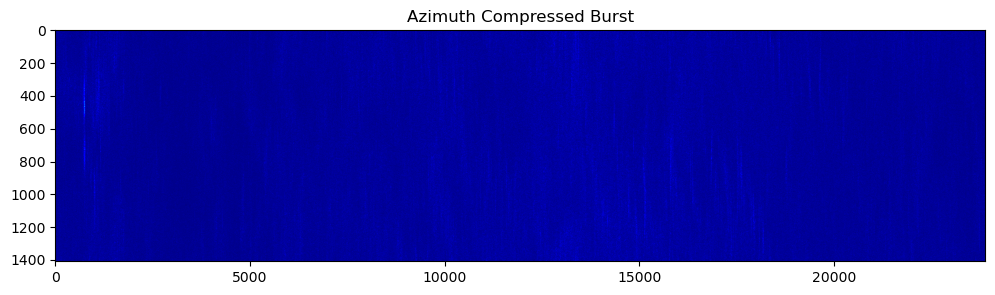

In [37]:
plot_signals(np.abs(azimuth) / np.max(np.abs(azimuth)), title="Azimuth Compressed Burst")
# plt.imshow(np.abs(azimuth) / np.max(np.abs(azimuth)), cmap='jet', vmax=0.2, aspect='auto')

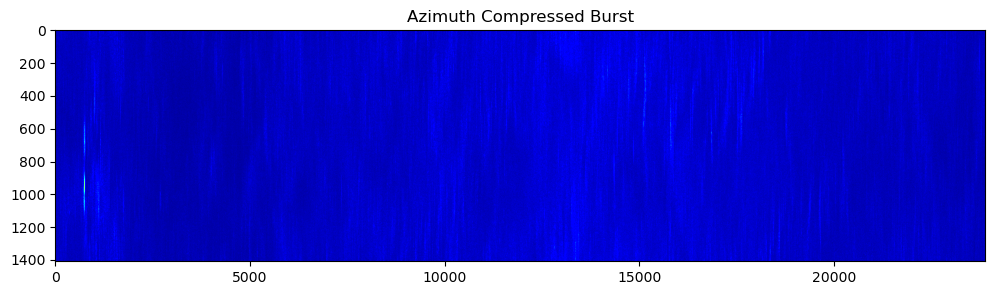

In [38]:
range_doppler_burst_f = ifftshift(range_doppler_burst, 0)
plot_signals(np.abs(range_doppler_burst_f) / np.max(np.abs(range_doppler_burst_f)), title="Azimuth Compressed Burst")

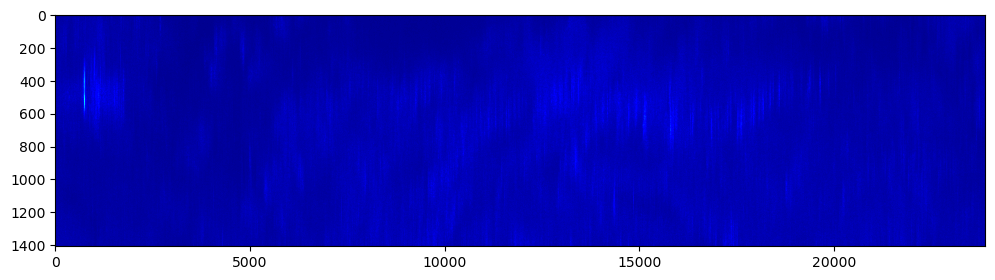

In [39]:
plot_signals(np.abs(range_azimuth_space) / np.max(np.abs(range_azimuth_space)))

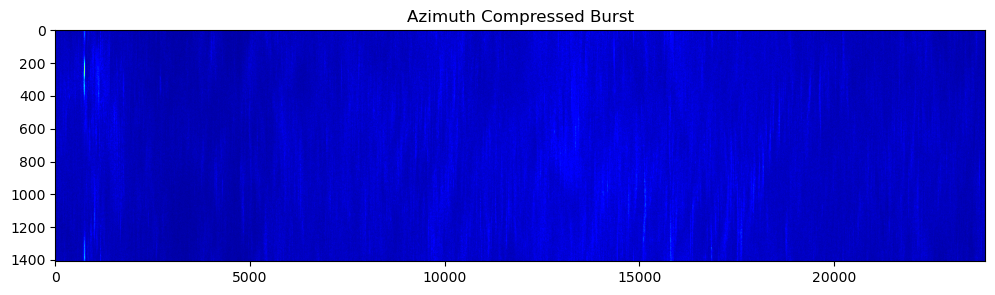

In [41]:
plot_signals(np.abs(range_doppler_burst) / np.max(np.abs(range_doppler_burst)), title="Azimuth Compressed Burst")

In [42]:
azimuth_steering_rate = 1.590368784000000e+00
wavelength = c / 5.405000454334350e+09
velocity = 7594.502898410107

doppler_centroid_rate = -1 * (2 * velocity / wavelength) * azimuth_steering_rate

In [43]:
from datetime import datetime, timedelta

def gps_time_to_seconds_since_midnight(gps_time_seconds):
    # Define the GPS epoch (January 6, 1980, 00:00:00 UTC)
    gps_epoch = datetime(1980, 1, 6)
    
    # Split the GPS time into seconds and fractional seconds
    whole_seconds = int(gps_time_seconds)
    fractional_seconds = gps_time_seconds - whole_seconds
    
    # Convert the GPS time (whole seconds) to a datetime object
    current_time = gps_epoch + timedelta(seconds=whole_seconds)
    
    # Get the number of seconds since the beginning of the day with sub-second precision
    seconds_since_midnight = (
        current_time.hour * 3600 +
        current_time.minute * 60 +
        current_time.second +
        fractional_seconds  # Add the fractional part
    )

    return seconds_since_midnight


first_line_time = (13 * 60 * 60) + (49 * 60) + 54.908760
last_line_time  = (13 * 60 * 60) + (50 * 60) + 22.681255

azimuth_samples = len(burst)

n = np.linspace(first_line_time, last_line_time, azimuth_samples)

burst_time = gps_time_to_seconds_since_midnight(header["coarse_time"] + (1 / header["fine_time"]))

gps_time_base = (2024 - 1980)

deramping_signal = np.exp(1j * pi * doppler_centroid_rate * (n - (burst_time / 2)**2))

In [44]:
def get_times(dicts):
    times = []
    for d in dicts[:-1]:
        gps_time = time_stamp_to_seconds(d["data_time_stamp"])
        data_time = gps_time_to_seconds_since_midnight(gps_time)
        times.append(data_time)
    return np.asarray(times)

def get_velocities(dicts):
    vs = []
    for d in dicts[:-1]:
        vx = d["x_axis_velocity"]
        vy = d["y_axis_velocity"]
        vz = d["z_axis_velocity"]
        norm = np.sqrt(vx**2 + vy**2 + vz**2)
        vs.append(norm)
    return np.asarray(vs, dtype=np.float64)

In [70]:
time_stamp_to_seconds(data_word_dicts[0]["data_time_stamp"])

1406987588.0

In [45]:
vs = get_velocities(data_word_dicts)
times = get_times(data_word_dicts)

print(time_stamp_to_seconds(data_word_dicts[-2]["data_time_stamp"]))

print("Times: ", times)
print("Velocities: ", vs)

1406987588.0
Times:  [49988. 49988. 49988. 49988. 49988. 49988. 49988. 49988. 49988. 49988.
 49988. 49988. 49988. 49988. 49988. 49988. 49988. 49988. 49988. 49988.
 49988. 49988.]
Velocities:  [7594.72303741 7594.72303741 7594.72303741 7594.72303741 7594.72303741
 7594.72303741 7594.72303741 7594.72303741 7594.72303741 7594.72303741
 7594.72303741 7594.72303741 7594.72303741 7594.72303741 7594.72303741
 7594.72303741 7594.72303741 7594.72303741 7594.72303741 7594.72303741
 7594.72303741 7594.73849738]


In [46]:
signals_fft = ifft(range_azimuth_space, axis=0)
signals_fft_norm = 20 * np.log10(np.abs(signals_fft) / np.max(np.abs(signals_fft)))

In [47]:
def calculate_azimuth_matched_filter(doppler_coeffs, azimuth_time, prf):
    """
    Calculates the azimuth matched filter based on Doppler centroid coefficients.
    
    Parameters:
        doppler_coeffs (list of float): Doppler centroid polynomial coefficients.
        azimuth_time (1D array): Array of azimuth time values (in seconds).
        prf (float): Pulse repetition frequency (PRF) of the radar.
        
    Returns:
        matched_filter (1D array): Azimuth matched filter (complex values).
    """
    # Compute Doppler frequency for each azimuth time (using the polynomial)
    doppler_freq = np.polyval(doppler_coeffs[::-1], azimuth_time)

    # Integrate Doppler frequency over azimuth time to get phase (phi)
    phase = 2 * np.pi * np.cumsum(doppler_freq) * (azimuth_time[1] - azimuth_time[0])

    # Calculate the matched filter (complex exponential of phase)
    matched_filter = np.exp(-1j * phase)
    
    return matched_filter

In [53]:
azimuth_time = np.linspace(-0.5, 0.5, 1409)
doppler_coeffs = [-0.49707, 61.38206, -7639.312] 

In [103]:
annot_file = open('../../sentinel1_decode/data/sample/sample_annot.dat', 'rb')
annot_records = annotation_decoder(annot_file)
index_file = open('../../sentinel1_decode/data/sample/sample_index.dat', 'rb')
index_records = index_decoder(index_file)

In [81]:
total_num_packets = 0
for i in range(10):
    total_num_packets += len(get_packets_in_burst(swath_packets, i))

In [98]:
annot_records_for_burst = []
for packet, packet_index in burst_:
    annot_records_for_burst.append(annot_records[packet_index])

In [109]:
annot_records_for_burst[3]

{'days_ul': 8984,
 'milliseconds_ul': 49971440,
 'microseconds_ul': 239,
 'days_dl': 8984,
 'milliseconds_dl': 52505317,
 'microseconds_dl': 633,
 'packet_length': 18981,
 'num_transfer_frames': 1,
 'error_flag': 0,
 'bit_1_type': 0,
 'bit_2_type': 0,
 'bit_6_type': 0,
 'spare_field': 1}

In [110]:
rec_1 = annot_records_for_burst[0]
time_1 = (rec_1["days_ul"]*24*60*60) + (rec_1["milliseconds_ul"]/1000) + (rec_1["microseconds_ul"]/1000000)

In [112]:
rec_2 = annot_records_for_burst[-1]
time_2 = (rec_2["days_ul"]*24*60*60) + (rec_2["milliseconds_ul"]/1000) + (rec_2["microseconds_ul"]/1000000)

In [116]:
azimuth_times = np.linspace(time_1, time_2, 1409)

In [129]:
doppler_coeffs = [-0.49707, 61.38206, -7639.312] 
amf = calculate_azimuth_matched_filter(doppler_coeffs, azimuth_time, prf)
range_azimuth_space = ifft(range_doppler_burst, axis=0)
azimuth = np.zeros((1409, range_doppler_burst.shape[1]), dtype=complex)
ras = np.zeros((1409, range_doppler_burst.shape[1]), dtype=complex)
ras[0:1409] = range_azimuth_space
for i in range(num_range):
    azimuth[:, i] = ifftshift(ifft(range_doppler_burst[:, i] * fft(amf))) # ifft(fft(range_azimuth_space[:, i]) * np.conj(az_chirps[i]))
# azimuth = ifftshift(ifft(azimuth, axis=0), 0)

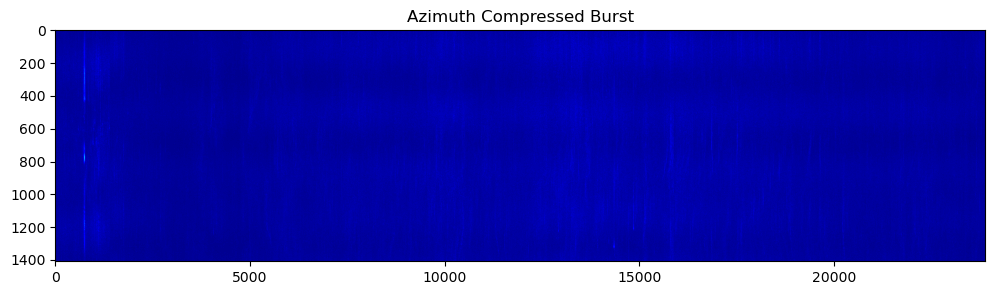

In [130]:
plot_signals(np.abs(azimuth) / np.max(np.abs(azimuth)), title="Azimuth Compressed Burst")